In [36]:
import numpy as np
from QAM_EncoderDecoder import * 
import commpy
from scipy.io.wavfile import write, read
import matplotlib.pyplot as plt
import sounddevice as sd
import soundfile as sf
from scipy.signal import csd, chirp
import binascii
from scipy.signal import correlate
from IPython.display import Audio
%matplotlib inline

1. Create a block of pseudo-random constellation values
2. Add chirp at beginning and transmit OFDM block repeatedly
3. Convolve with inverse chirp to synchronise
4. Trim to just OFDM blocks
5. Average to block length n, take DFT, divide by tx constellation values to recover channel tf
6. Take iDFT to get impulse response of channel

In [839]:
N = 1024 # for dft length, no symbols
prefix_no = 32
fs = 44100

#random_symbol = np.random.randint(0,100, int(N/4)) # easier to test if same every time
# NEED TO CHANGE TO PSEUDO RANDOM SIGNALS
random_symbol

array([81, 41, 51, 46, 19, 27, 84, 53,  0, 86, 54, 17, 33, 32,  8, 24, 19,
       38, 58, 28, 74, 10, 39, 24, 39, 22, 59, 58, 70, 74, 82, 64,  4, 77,
       98, 50, 26, 36, 21, 32, 56, 27, 92, 42, 63, 91, 67, 76, 65, 40, 17,
       49, 66, 42, 87, 20, 50, 89, 48, 47, 40, 29, 57, 40, 92, 73,  8, 26,
       12, 76, 24, 82, 43, 14, 40, 19, 56, 97, 78, 43, 96, 43, 89,  6, 11,
       98, 58, 25, 91, 16, 40, 77, 52,  9, 34, 45, 36, 69, 12, 29, 38, 45,
       88, 14, 20, 49,  1, 61, 48, 36, 10, 44, 44,  5,  7, 34, 26, 72,  7,
       63, 68, 27, 12, 71, 39, 54, 96,  1, 70, 67, 76, 30, 77, 73, 28, 88,
       31, 17, 86, 62,  1, 12, 35, 74,  3, 87, 73, 26, 83, 73,  6,  3, 32,
       37, 39, 53, 90, 88, 60, 89, 93, 91,  4, 53,  5,  4,  4, 58, 35, 63,
       27, 77, 51, 87, 24, 31, 16,  4, 87, 98, 52, 90, 68, 37, 75, 56, 34,
       30, 50, 26, 20, 96, 51, 94, 60, 55, 14, 74,  4, 73, 13, 45, 67,  8,
       61, 12, 93,  6, 87, 14, 90, 64, 33, 29, 68, 13, 60, 18,  9, 60,  3,
       15,  6, 48, 34, 44

about to do encode_bitstr2symbols encoding
encode_bitstr2symbols encoding finished
1024
1024


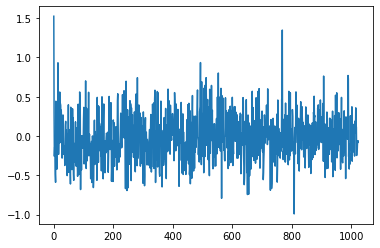

In [889]:
bin_strings=''
for byte in random_symbol:
    binary_string = '{0:08b}'.format(byte)
    bin_strings+=binary_string
bin_strings

symbols = encode_bitstr2symbols(bin_strings)
print(len(symbols))
#frame = symbol_to_OFDMframes(symbols, len(symbols), prefix_no)[0] # original shape is (1, 1056)
frame = np.fft.ifft(symbols)
frame = np.real(frame)*10 # already has 0j part so make it real type
print(len(frame))
plt.plot(frame)

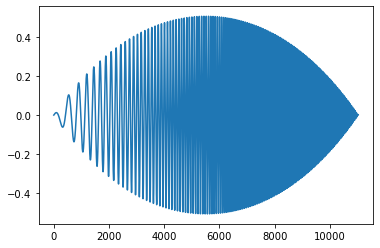

In [890]:
# linear chirp but can do log one
sec = 0.25

k = 10
fl = 60
fu = 1000

t = np.linspace(0, sec, int(fs*sec))
ch = chirp(t, f0=fl, f1=fu, t1=sec, method='linear') # can be linear, quadratic or logarithmic
ch *= (1-np.exp(-k*t))*(1-np.exp(-k*(sec-t)))

ch = np.tile(ch, 1) # repeat num chirps

plt.plot(ch)

Chirp 1 starts at: 4410   OFDM starts at:  19845 Chirp 2 starts at:  126655
Transmitted diff:  15435


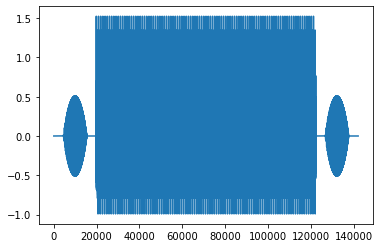

In [891]:
repeats = 100
repeat = np.tile(frame, repeats) # transmit repeated frames
gap = int(0.1*fs)
combined = np.concatenate((np.zeros(gap), ch, np.zeros(gap), repeat, np.zeros(gap), ch, np.zeros(gap)), axis=None)
print("Chirp 1 starts at:", gap, "  OFDM starts at: ", (2*gap)+len(ch), "Chirp 2 starts at: ", (3*gap)+len(ch)+len(repeat))
tx_diff = gap + len(ch)
print("Transmitted diff: ", tx_diff)
plt.plot(combined)

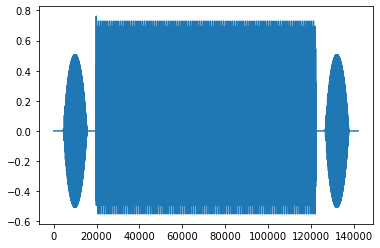

In [892]:
channel = [0.5, 0.25, 0, 0.25]
channel_op = np.convolve(channel, combined)
plt.plot(channel_op)

In [893]:
####### OR

sd.play(combined, fs)
sf.write('sync5.wav', combined, fs)

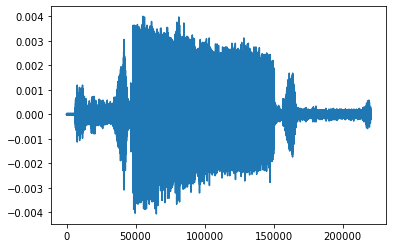

In [894]:
seconds = 5

recording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
sd.wait()

sf.write('syn4_rec.wav', recording, fs)
plt.plot(recording)

channel_op = recording[:, 0] 

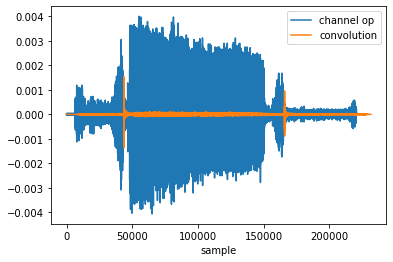

In [895]:
T = 0.0
inverse_ch = np.concatenate((np.zeros(int(T*fs)), np.flip(ch)), axis=None) # time reverse and delay the chirp
conv = np.convolve(channel_op, inverse_ch)
plt.plot(channel_op, label='channel op')
plt.plot(conv/1000, label='convolution')
plt.xlabel('sample')
plt.legend(loc='upper right')

Convolution peak 1: 43623
Convolution peak 2: 165869


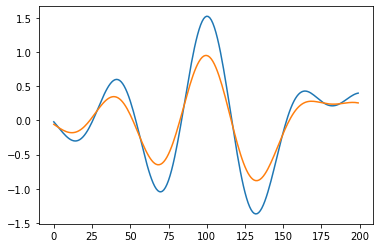

In [896]:
peak1 = np.argmax(conv[0:int(len(conv)/2)])
peak2 = np.argmax(conv[int(len(conv)/2):]) + int(len(conv)/2) + 0
print("Convolution peak 1:", peak1)
print("Convolution peak 2:", peak2)
plt.plot(conv[peak1-100:peak1+100])
plt.plot(conv[peak2-100:peak2+100])

48013 150414 102401
OFDM begins at:  48013
102400
Diff:  28168


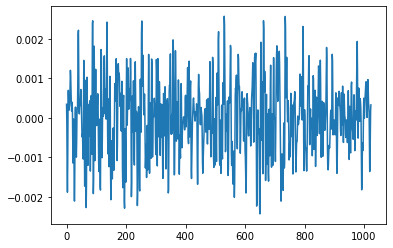

In [898]:
offset = -20 # current rough synchronisation error
rx_begin = peak1 + gap - int(T*fs) + offset # channel IR adjusts this value
rx_end = peak2 - gap - len(ch) - int(T*fs) + offset
print(rx_begin, rx_end, rx_end - rx_begin)
print("OFDM begins at: ", rx_begin) # offset proportional to length of channel IR
rx_OFDM = channel_op[rx_begin:rx_end][:-1] # mismatch between length of frames expected & received
print(len(rx_OFDM))
frames = np.split(rx_OFDM, repeats)
avg_frame = np.zeros(N)
for frame in frames:
    avg_frame = np.add(avg_frame, frame)
avg_frame /= repeats
#print(avg_frame)
plt.plot(avg_frame)
print("Diff: ", rx_begin - ((2*gap)+len(ch))) # number of symbol periods off

C:\Users\11kir\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


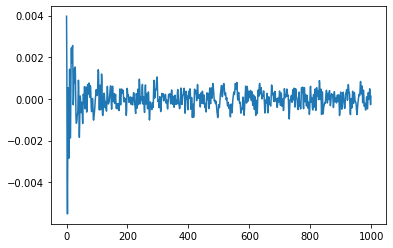

In [900]:
rx_dft = np.fft.fft(avg_frame)
norm_rx_dft = rx_dft / np.array(symbols)

imp_response = np.fft.ifft(norm_rx_dft)
#imp_response /= np.linalg.norm(imp_response)
plt.plot((imp_response)[0:1000])
#print(imp_response[0:100])